# Importing libraies & loading datasets

In [1]:
# basic library import
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import seaborn as sns
from IPython.display import Image

# library for SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler # this is for normalising our data

# library for Neural Network
import tensorflow.keras as keras
import tensorflow as tf

# library for confusion matrix
from sklearn.metrics import plot_confusion_matrix

trnImages = np.load('trnImage.npy')
tstImages = np.load('tstImage.npy')

trnLabel = np.load('trnLabel.npy')
tstLabel = np.load('tstLabel.npy')

# Data pre-processing

In [2]:
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

# Extract the features from a single image
def takeFeatures(data):
    returnData = np.array([])
    
    for i in range(data.shape[3]):
        features, hogImg = computeFeatures(data[:,:,:,i])
        if i == 0:
            returnData = np.array([features])
        else:
            returnData = np.concatenate((returnData, [features]))
    return returnData

# Transforming the label to a better format
def transformLabel(label):
    newArray = np.array([])

    for i in range(label.shape[0]):
        [a] = label[i]
        if i == 0:
            newArray = np.array([a])
        else:
            newArray = np.concatenate((newArray, [a]))
    return newArray

In [3]:
# Pre-process the data
trnData = takeFeatures(trnImages)
tstData = takeFeatures(tstImages)

labelForTrn = transformLabel(trnLabel)
labelForTst = transformLabel(tstLabel)

# SVM implementation

In [4]:
# A function for implementing SVM
def SVM(trnData, labelForTrn, tstData, labelForTst):
    
    # Normalise the data with respect to the training set
    normaliser = StandardScaler().fit(trnData)
    trnData = normaliser.transform(trnData)
    tstData = normaliser.transform(tstData)

    # Create an instance of the svm.SVC model.
    # Set the penalty.
    C = 1
    SVM_model = SVC(kernel='linear', C=C)

    # Fit the model to the dataset, given the labels.
    SVM_model.fit(trnData, labelForTrn)

    # Use the model to predict the class of the test observations.
    predicted_labels = SVM_model.predict(tstData)

    # Calculate the percentage accuracy rate on test set
    accuracy = np.sum(np.equal(labelForTst, predicted_labels)) / labelForTst.shape[0] * 100
    
    return predicted_labels, accuracy

# Neural network implementation

In [5]:
# A function for implementing Neural Networks
def NN(trnData, labelForTrn, tstData, labelForTst):
    
    number_of_classes = np.max(labelForTrn) + 1

    # Normalise the data based on the training set
    normaliser = StandardScaler().fit(trnData)
    trnData = normaliser.transform(trnData)
    tstData = normaliser.transform(tstData)

    # Build our network architecture by stacking layers in a Keras Sequential object.
    NN_model = keras.Sequential()

    # Create the input layer, this takes an argument of the input data shape (i.e. number of features)
    NN_model.add(keras.layers.InputLayer(input_shape=(trnData.shape[1],)))

    # Create hidden layers
    NN_model.add(keras.layers.Dense(9, activation='sigmoid')) # first layer

    # Create output layer to get predicted class labels.
    NN_model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

    # Generate a callable keras Model object which contains our architecture.
    # This allows us to train and predict our neural network on the datasets.
    NN_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])

    # Fit our model to the data
    history = NN_model.fit(trnData, labelForTrn, validation_data=(tstData, labelForTst), epochs=1000, verbose=0)

    # Predict probabilities of classes for the testing set.
    predicted_probabilities = NN_model.predict(tstData)

    # Use argmax to get the predicted class label
    predicted_labels = np.argmax(predicted_probabilities, axis=1)

    # Calculate the percentage accuracy rate on test set
    accuracy = np.sum(np.equal(labelForTst, predicted_labels)) / labelForTst.shape[0] * 100
    
    return predicted_labels, accuracy

# Confusion Matrix implementation

In [6]:
# A function for creating confusion matrix
def conMat(preLab, labelForTst):
    
    con_mat = tf.math.confusion_matrix(labels=labelForTst, predictions=preLab).numpy()
    
    # Normalise the matrix
    con_mat_norm = np.around(con_mat.astype('float') / 100, decimals=2)

    figure = plt.figure(figsize=(5.5, 5.5))
    
    # Plot it with a heatmap 
    sns.heatmap(con_mat_norm, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

# Results for SVM

Percentage accuracy on testing set is: 48.50%


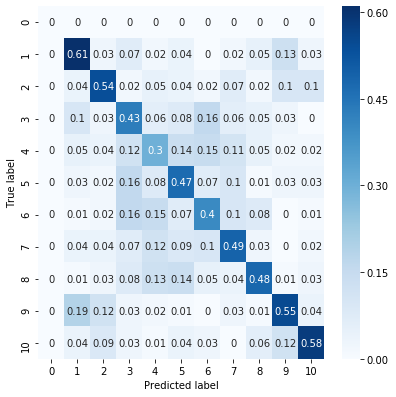

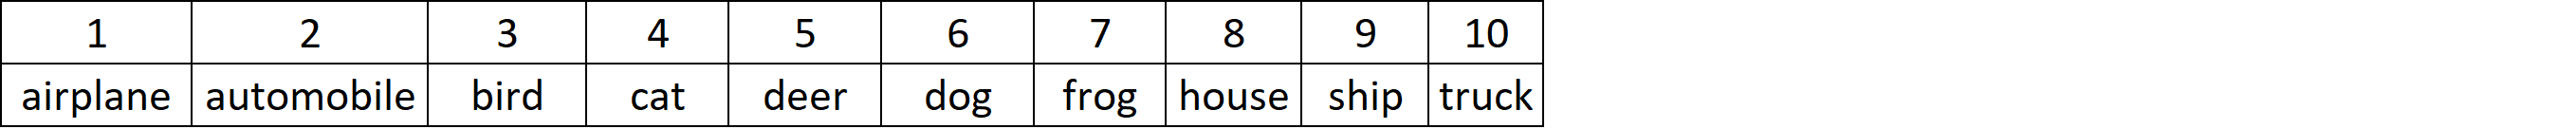

In [7]:
# Run the SVM function
SVM_predicted_labels, SVM_accuracy = SVM(trnData, labelForTrn, tstData, labelForTst)

# Report the percentage accuracy 
print('Percentage accuracy on testing set is: {0:.2f}%'.format(SVM_accuracy))

# Create the confusion matrix for SVM
conMat(SVM_predicted_labels, labelForTst)
Image(filename='lookup.png') 

# Results for Neural Network

Percentage accuracy on testing set is: 47.70%


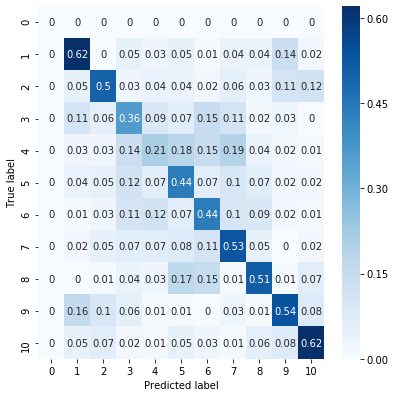

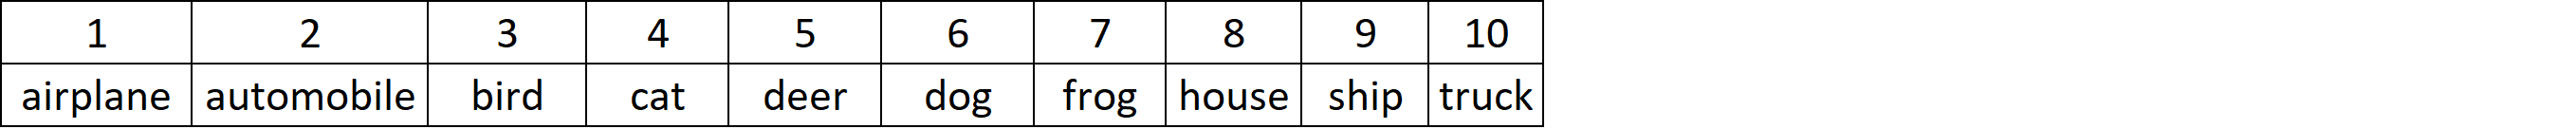

In [8]:
# Run the Neural Network function
NN_predicted_labels, NN_accuracy = NN(trnData, labelForTrn, tstData, labelForTst)

# Report the percentage accuracy
print('Percentage accuracy on testing set is: {0:.2f}%'.format(NN_accuracy))

# Create the confusion matrix for Neural Network
conMat(NN_predicted_labels, labelForTst)
Image(filename='lookup.png') 